# Jupyter Notebook: Load OSHA Case Detail CSV and Prepare for Analysis


🔄 Loading ZIP to County FIPS crosswalk...
✅ Loaded crosswalk with 54260 zip-to-county mappings

🔄 Loading OSHA 300A Summary Files (2016-2022)...
📂 Found 7 summary files: ['ITA Data CY 2016.csv', 'ITA Data CY 2017.csv', 'ITA Data CY 2018.csv', 'ITA Data CY 2019.csv', 'ITA Data CY 2020.csv', 'ITA Data CY 2021.csv', 'ITA Data CY 2022.csv']
📊 ITA Data CY 2016.csv initial row count: 214978
📝 Added year column with value 2016
🔍 Deriving county_fips from zip_code
⚠️ Row count changed after merge: 214978 -> 302919
📊 County FIPS match rate: 96.98%
📝 Dropped 9152 rows with missing required values
📝 NAICS filter kept 1187/293767 rows (0.4%)
✅ Loaded ITA Data CY 2016.csv with 1187 rows
📊 ITA Data CY 2017.csv initial row count: 259758
📝 Added year column with value 2017
🔍 Deriving county_fips from zip_code
⚠️ Row count changed after merge: 259758 -> 355552
📊 County FIPS match rate: 94.95%
📝 Dropped 17966 rows with missing required values
📝 NAICS filter kept 1007/337586 rows (0.3%)
✅ Loaded ITA Data

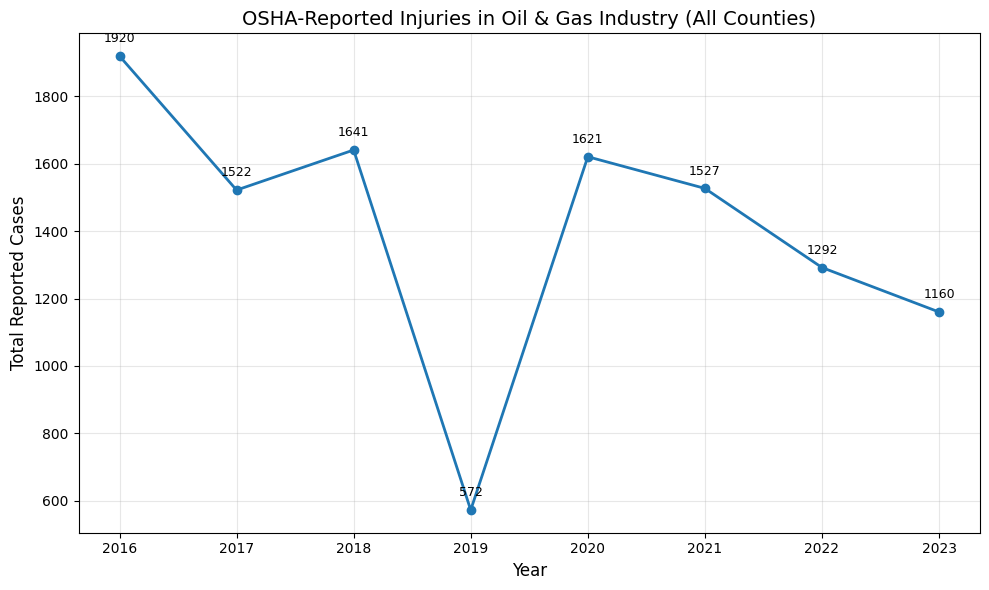

✅ Visualization created and saved.
✅ Processing complete


In [4]:
import os
import zipfile
import requests
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------
# Step 1: Load ZIP to County FIPS Crosswalk (needed early)
# ----------------------------------------

def load_crosswalk():
    print("🔄 Loading ZIP to County FIPS crosswalk...")
    crosswalk_path = os.path.expanduser("~/Downloads/ZIP_COUNTY_122021.xlsx")
    zip_xwalk = pd.read_excel(crosswalk_path, dtype=str)
    
    # Rename and filter
    zip_xwalk = zip_xwalk.rename(columns={"zip": "zip_code", "county": "county_fips"})
    zip_xwalk = zip_xwalk[["zip_code", "county_fips"]].drop_duplicates()
    
    # Fix zip code format - ensure 5 digits
    zip_xwalk["zip_code"] = zip_xwalk["zip_code"].str.zfill(5)
    
    print(f"✅ Loaded crosswalk with {len(zip_xwalk)} zip-to-county mappings")
    return zip_xwalk

# ----------------------------------------
# Step 2: Load OSHA 300A Summary Files (2016–2022)
# ----------------------------------------

def load_summary_files(summary_dir, zip_xwalk):
    print("\n🔄 Loading OSHA 300A Summary Files (2016-2022)...")
    
    summary_files = [
        f for f in os.listdir(summary_dir)
        if f.endswith(".csv") and f.startswith("ITA Data CY") and any(str(y) in f for y in range(2016, 2023))
    ]
    
    # Sort files chronologically
    summary_files.sort()
    print(f"📂 Found {len(summary_files)} summary files: {summary_files}")
    
    summary_frames = []
    for fname in summary_files:
        file_path = os.path.join(summary_dir, fname)
        try:
            # Try different encodings
            try:
                df_temp = pd.read_csv(file_path, low_memory=False)
            except UnicodeDecodeError:
                df_temp = pd.read_csv(file_path, low_memory=False, encoding='latin-1')
                print(f"📝 Used latin-1 encoding for {fname}")
            
            # Initial row count
            original_row_count = len(df_temp)
            print(f"📊 {fname} initial row count: {original_row_count}")
            
            # Convert column names to lowercase
            df_temp.columns = df_temp.columns.str.lower()
            
            # Rename columns for consistency
            df_temp = df_temp.rename(columns={
                "naics": "naics_code",
                "naicscode": "naics_code",
                "totalcases": "total_cases",
                "no_injuries_illnesses": "total_cases",
            })
            
            # Calculate total cases if missing but component fields exist
            if "total_cases" not in df_temp.columns:
                if all(col in df_temp.columns for col in ["total_dafw_cases", "total_djtr_cases", "total_other_cases"]):
                    df_temp["total_cases"] = df_temp["total_dafw_cases"] + df_temp["total_djtr_cases"] + df_temp["total_other_cases"]
                    print(f"📝 Created total_cases from component fields")
            
            # Add year if missing
            if "year" not in df_temp.columns:
                inferred_year = ''.join(filter(str.isdigit, fname))[-4:]
                df_temp["year"] = inferred_year
                print(f"📝 Added year column with value {inferred_year}")
            
            # Handle county_fips
            if "county_fips" not in df_temp.columns:
                candidate_cols = [c for c in df_temp.columns if "county" in c.lower() and "fips" in c.lower()]
                
                for c in candidate_cols:
                    if df_temp[c].notna().any():
                        df_temp["county_fips"] = df_temp[c]
                        print(f"📝 Used {c} as county_fips")
                        break
            
            # If still no county_fips, try to derive from zip_code
            if "county_fips" not in df_temp.columns or df_temp["county_fips"].isna().all():
                if "zip_code" in df_temp.columns:
                    print(f"🔍 Deriving county_fips from zip_code")
                    
                    # Fix zip code format
                    df_temp["zip_code"] = df_temp["zip_code"].astype(str)
                    df_temp["zip_code"] = df_temp["zip_code"].str.replace('.0', '', regex=False)
                    df_temp["zip_code"] = df_temp["zip_code"].str.zfill(5)
                    
                    # Merge with crosswalk
                    before_merge = len(df_temp)
                    df_temp = df_temp.merge(zip_xwalk, on="zip_code", how="left")
                    after_merge = len(df_temp)
                    
                    if before_merge != after_merge:
                        print(f"⚠️ Row count changed after merge: {before_merge} -> {after_merge}")
                    
                    null_count = df_temp["county_fips"].isna().sum()
                    match_rate = 1 - (null_count / len(df_temp)) if len(df_temp) > 0 else 0
                    print(f"📊 County FIPS match rate: {match_rate:.2%}")
            
            # Convert important columns to numeric
            numeric_cols = ["total_cases"]
            for col in numeric_cols:
                if col in df_temp.columns:
                    df_temp[col] = pd.to_numeric(df_temp[col], errors="coerce")
            
            # Filter for required fields
            required = ["year", "total_cases", "county_fips"]
            before_drop = len(df_temp)
            df_temp = df_temp.dropna(subset=required)
            after_drop = len(df_temp)
            
            if before_drop > after_drop:
                print(f"📝 Dropped {before_drop - after_drop} rows with missing required values")
            
            # Filter for oil & gas NAICS codes
            if "naics_code" in df_temp.columns:
                df_temp["naics_code"] = df_temp["naics_code"].astype(str).str.strip()
                
                before_filter = len(df_temp)
                df_temp = df_temp[
                    df_temp["naics_code"].str.startswith("211") |
                    df_temp["naics_code"].isin(["213111", "213112"])
                ]
                after_filter = len(df_temp)
                
                if before_filter > 0 and after_filter == 0:
                    print(f"⚠️ NAICS filter removed all rows! No oil & gas industry data found.")
                    # Show sample of NAICS codes
                    naics_sample = df_temp["naics_code"].value_counts().head(5)
                    print(f"📊 Most common NAICS codes: {dict(naics_sample)}")
                elif before_filter > after_filter:
                    print(f"📝 NAICS filter kept {after_filter}/{before_filter} rows ({after_filter/before_filter:.1%})")
            
            # Add to result frames
            if len(df_temp) > 0:
                summary_frames.append(df_temp)
                print(f"✅ Loaded {fname} with {len(df_temp)} rows")
            else:
                print(f"⚠️ No usable data in {fname} after filtering")
            
        except Exception as e:
            print(f"❌ Failed to load from {fname}: {e}")
            import traceback
            print(traceback.format_exc())
    
    return summary_frames

# ----------------------------------------
# Step 3: Load OSHA Case Detail Files (2023-2024)
# ----------------------------------------

def load_case_detail_files(summary_dir, zip_xwalk):
    print("\n🔄 Loading OSHA Case Detail Files (2023-2024)...")
    
    case_detail_files = [
        f for f in os.listdir(summary_dir)
        if f.endswith(".csv") and f.startswith("ITA Data CY") and any(str(y) in f for y in range(2023, 2025))
    ]
    
    case_detail_files.sort()
    print(f"📂 Found {len(case_detail_files)} case detail files: {case_detail_files}")
    
    detail_frames = []
    for fname in case_detail_files:
        file_path = os.path.join(summary_dir, fname)
        try:
            # Try different encodings
            try:
                df_temp = pd.read_csv(file_path, low_memory=False, encoding_errors='ignore')
            except Exception:
                df_temp = pd.read_csv(file_path, low_memory=False, encoding='latin-1')
                print(f"📝 Used latin-1 encoding for {fname}")
            
            # Initial row count
            original_row_count = len(df_temp)
            print(f"📊 {fname} initial row count: {original_row_count}")
            
            # Convert column names to lowercase
            df_temp.columns = df_temp.columns.str.lower()
            
            # Print column names for debug
            print(f"🔍 Available columns sample: {df_temp.columns[:10].tolist()}")
            
            # Add year if missing
            if "year" not in df_temp.columns:
                if "year_filing_for" in df_temp.columns:
                    df_temp["year"] = df_temp["year_filing_for"]
                    print(f"📝 Used year_filing_for as year")
                else:
                    inferred_year = ''.join(filter(str.isdigit, fname))[-4:]
                    df_temp["year"] = inferred_year
                    print(f"📝 Added year column with value {inferred_year}")
            
            # Handle county_fips
            if "county_fips" not in df_temp.columns:
                candidate_cols = [c for c in df_temp.columns if "county" in c.lower() and "fips" in c.lower()]
                
                for c in candidate_cols:
                    if df_temp[c].notna().any():
                        df_temp["county_fips"] = df_temp[c]
                        print(f"📝 Used {c} as county_fips")
                        break
            
            # If still no county_fips, try to derive from zip_code
            if "county_fips" not in df_temp.columns or df_temp["county_fips"].isna().all():
                if "zip_code" in df_temp.columns:
                    print(f"🔍 Deriving county_fips from zip_code")
                    
                    # Fix zip code format
                    df_temp["zip_code"] = df_temp["zip_code"].astype(str)
                    df_temp["zip_code"] = df_temp["zip_code"].str.replace('.0', '', regex=False)
                    df_temp["zip_code"] = df_temp["zip_code"].str.zfill(5)
                    
                    # Print sample for debugging
                    print(f"📊 Sample of formatted zip_codes: {df_temp['zip_code'].head(5).tolist()}")
                    
                    # Merge with crosswalk
                    before_merge = len(df_temp)
                    df_temp = df_temp.merge(zip_xwalk, on="zip_code", how="left")
                    after_merge = len(df_temp)
                    
                    if before_merge != after_merge:
                        print(f"⚠️ Row count changed after merge: {before_merge} -> {after_merge}")
                    
                    null_count = df_temp["county_fips"].isna().sum()
                    match_rate = 1 - (null_count / len(df_temp)) if len(df_temp) > 0 else 0
                    print(f"📊 County FIPS match rate: {match_rate:.2%}")
            
            # Calculate total_cases for detailed data (different from 300A structure)
            # IMPORTANT: Create total_cases BEFORE filtering required fields
            if "total_cases" not in df_temp.columns:
                # First check for existing injury fields
                if all(col in df_temp.columns for col in ["dafw_num_away", "djtr_num_tr"]):
                    df_temp["dafw_num_away"] = pd.to_numeric(df_temp["dafw_num_away"], errors="coerce").fillna(0)
                    df_temp["djtr_num_tr"] = pd.to_numeric(df_temp["djtr_num_tr"], errors="coerce").fillna(0)
                    df_temp["total_cases"] = 1  # Each row is one case
                    print(f"📝 Set total_cases=1 for each row (case detail format)")
                # For 2024 files that might have different structure
                elif "2024" in fname:
                    # Look for alternative injury columns
                    injury_cols = [c for c in df_temp.columns if any(term in c.lower() for term in 
                                                                  ["injury", "illness", "case", "dafw", "djtr"])]
                    print(f"📊 Potential injury columns: {injury_cols[:5]}...")
                    
                    # Set total_cases to 1 for all rows (each row represents one case)
                    df_temp["total_cases"] = 1
                    print(f"📝 Created total_cases=1 for 2024 data (case detail format)")
                else:
                    # Fallback - create a total_cases column with value 1
                    df_temp["total_cases"] = 1
                    print(f"📝 Created default total_cases=1 for each row")
            
            # Now filter for required fields
            required = ["year", "county_fips", "total_cases"]
            before_drop = len(df_temp)
            df_temp = df_temp.dropna(subset=required)
            after_drop = len(df_temp)
            
            if before_drop > after_drop:
                print(f"📝 Dropped {before_drop - after_drop} rows with missing required values")
            
            # Filter for oil & gas NAICS codes
            if "naics_code" in df_temp.columns:
                df_temp["naics_code"] = df_temp["naics_code"].astype(str).str.strip()
                
                # Count potential target rows
                target_count = (df_temp["naics_code"].str.startswith("211") | 
                               df_temp["naics_code"].isin(["213111", "213112"])).sum()
                print(f"📊 Found {target_count} rows with oil & gas NAICS codes")
                
                if target_count == 0:
                    # Show sample of NAICS codes
                    naics_sample = df_temp["naics_code"].value_counts().head(5)
                    print(f"📊 Most common NAICS codes: {dict(naics_sample)}")
                
                # Apply the filter
                before_filter = len(df_temp)
                df_temp = df_temp[
                    df_temp["naics_code"].str.startswith("211") |
                    df_temp["naics_code"].isin(["213111", "213112"])
                ]
                after_filter = len(df_temp)
                
                if before_filter > 0 and after_filter == 0:
                    print(f"⚠️ NAICS filter removed all rows. No oil & gas industry data found.")
                elif before_filter > after_filter:
                    print(f"📝 NAICS filter kept {after_filter}/{before_filter} rows ({after_filter/before_filter:.1%})")
            
            # Add to result frames
            if len(df_temp) > 0:
                detail_frames.append(df_temp)
                print(f"✅ Loaded {fname} with {len(df_temp)} rows")
            else:
                print(f"⚠️ No usable data in {fname} after filtering")
            
        except Exception as e:
            print(f"❌ Failed to load from {fname}: {e}")
            import traceback
            print(traceback.format_exc())
    
    return detail_frames
# ----------------------------------------

# ----------------------------------------
# Step 4: Combine data and aggregate
# ----------------------------------------
    
def process_and_aggregate_data(summary_frames, detail_frames):
    print("\n🔄 Combining and aggregating data...")
    
    # Combine all frames
    all_frames = summary_frames + detail_frames
    
    if len(all_frames) == 0:
        print("❌ No data frames to process. Check previous steps.")
        return None
    
    # Ensure consistent column structure for each type before combining
    print(f"📊 Processing {len(all_frames)} data frames")
    
    combined_df = pd.concat(all_frames, ignore_index=True)
    print(f"📊 Combined data shape: {combined_df.shape}")
    
    # Ensure year is string type for consistent grouping
    combined_df["year"] = combined_df["year"].astype(str)
    combined_df["county_fips"] = combined_df["county_fips"].astype(str)
    
    # Check for missing values in key columns
    for col in ["year", "county_fips", "total_cases"]:
        missing = combined_df[col].isna().sum()
        print(f"📊 Missing values in {col}: {missing} ({missing/len(combined_df):.2%})")
    
    # Group by county and year
    agg = combined_df.groupby(["county_fips", "year"]).agg(
        total_cases=("total_cases", "sum")
    ).reset_index()
    
    # If available, include injury detail columns
    detail_cols = ["dafw_num_away", "djtr_num_tr"]
    if all(col in combined_df.columns for col in detail_cols):
        print("📊 Adding detailed injury categories to aggregation")
        agg_detailed = combined_df.groupby(["county_fips", "year"]).agg(
            total_cases=("total_cases", "sum"),
            total_dafw=("dafw_num_away", "sum"),
            total_djtr=("djtr_num_tr", "sum")
        ).reset_index()
        
        if len(agg_detailed) > 0:
            agg = agg_detailed
    
    print(f"📊 Aggregated to {len(agg)} county-year combinations")
    print("📊 Sample of aggregated data:")
    print(agg.head())
    
    # Export to CSV as backup
    agg.to_csv("osha_summary_by_county_year.csv", index=False)
    print("✅ Exported aggregated data to CSV backup")
    
    return agg

# ----------------------------------------
# Main execution
# ---------------------------------------  
def main():
    # Directory with data files
    summary_dir = os.path.expanduser("~/Downloads")
    
    # Load the crosswalk file
    zip_xwalk = load_crosswalk()
    
    # Load summary files (2016-2022)
    summary_frames = load_summary_files(summary_dir, zip_xwalk)
    print(f"📊 Loaded {len(summary_frames)} summary data frames")
    
    # Load case detail files (2023-2024)
    detail_frames = load_case_detail_files(summary_dir, zip_xwalk)
    print(f"📊 Loaded {len(detail_frames)} case detail data frames")
    
    # Process and aggregate all data
    agg_data = process_and_aggregate_data(summary_frames, detail_frames)
    
    if agg_data is not None:
        try:
            # Import database dependencies
            from sqlalchemy import create_engine
            from dotenv import load_dotenv
            
            # Load database credentials
            load_dotenv()
            
            # Create database connection
            connection_string = f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
            engine = create_engine(connection_string)
            
            # Load aggregated data to database
            agg_data.to_sql("osha_summary", engine, if_exists="replace", index=False)
            print("✅ Aggregated data loaded to 'osha_summary' table.")
            
            # Create visualization
            import matplotlib.pyplot as plt
            
            # Plot total cases by year summed across counties
            fig, ax = plt.subplots(figsize=(10, 6))
            agg_year = agg_data.groupby("year")["total_cases"].sum().reset_index()
            
            # Sort by year
            agg_year["year"] = pd.to_numeric(agg_year["year"])
            agg_year = agg_year.sort_values("year")
            
            # Create plot
            ax.plot(agg_year["year"], agg_year["total_cases"], marker="o", linewidth=2)
            ax.set_title("OSHA-Reported Injuries in Oil & Gas Industry (All Counties)", fontsize=14)
            ax.set_xlabel("Year", fontsize=12)
            ax.set_ylabel("Total Reported Cases", fontsize=12)
            
            # Add data labels
            for x, y in zip(agg_year["year"], agg_year["total_cases"]):
                ax.annotate(f"{int(y)}", 
                          xy=(x, y),
                          xytext=(0, 10),
                          textcoords="offset points",
                          ha='center', 
                          fontsize=9)
            
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            
            # Save the plot
            plt.savefig("osha_injuries_by_year.png", dpi=300)
            plt.show()
            
            print("✅ Visualization created and saved.")
            
        except Exception as e:
            print(f"❌ Error in database or visualization step: {e}")
            import traceback
            print(traceback.format_exc())
    
    print("✅ Processing complete")

if __name__ == "__main__":
    main()


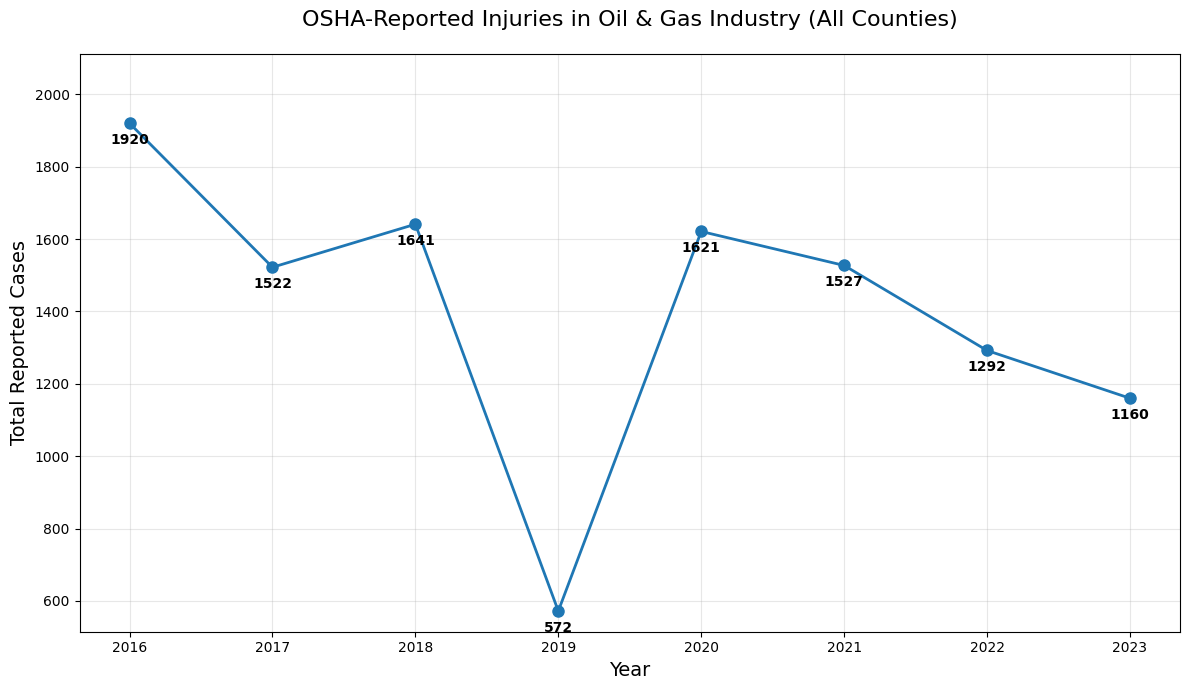

✅ Visualization with 8 years created and saved.

Yearly totals:
 year  total_cases
 2016       1920.0
 2017       1522.0
 2018       1641.0
 2019        572.0
 2020       1621.0
 2021       1527.0
 2022       1292.0
 2023       1160.0


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_osha_trends(csv_path="osha_summary_by_county_year.csv"):
    # Load the aggregated data
    agg_data = pd.read_csv(csv_path)
    
    # Convert year to numeric to ensure proper sorting
    agg_data["year"] = pd.to_numeric(agg_data["year"])
    
    # Sum cases by year
    agg_year = agg_data.groupby("year")["total_cases"].sum().reset_index()
    
    # Sort by year to ensure chronological order
    agg_year = agg_year.sort_values("year")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Create line plot
    ax.plot(agg_year["year"], agg_year["total_cases"], 
            marker="o", linewidth=2, color="#1f77b4", markersize=8)
    
    # Add data labels
    for x, y in zip(agg_year["year"], agg_year["total_cases"]):
        ax.annotate(f"{int(y)}", 
                  xy=(x, y),
                  xytext=(0, -15),
                  textcoords="offset points",
                  ha='center',
                  fontsize=10,
                  fontweight='bold')
    
    # Set title and labels
    ax.set_title("OSHA-Reported Injuries in Oil & Gas Industry (All Counties)", 
                fontsize=16, pad=20)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Total Reported Cases", fontsize=14)
    
    # Improve grid appearance
    ax.grid(True, alpha=0.3)
    
    # Set y axis to start at a reasonable value below minimum
    y_min = max(0, agg_year["total_cases"].min() * 0.9)
    y_max = agg_year["total_cases"].max() * 1.1
    ax.set_ylim(y_min, y_max)
    
    # Ensure x-axis shows all years
    all_years = range(agg_year["year"].min(), agg_year["year"].max() + 1)
    ax.set_xticks(all_years)
    ax.set_xticklabels(all_years, rotation=0)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save and show the plot
    plt.savefig("osha_injuries_by_year_all.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print(f"✅ Visualization with {len(agg_year)} years created and saved.")
    
    # Return data for reference
    return agg_year

# Run the function
if __name__ == "__main__":
    year_data = plot_osha_trends()
    print("\nYearly totals:")
    print(year_data.to_string(index=False))

In [7]:
# Create OSHA injuries table SQL
create_osha_table_sql = """
CREATE TABLE IF NOT EXISTS osha_injuries (
    county_fips VARCHAR REFERENCES counties(county_fips),
    year INTEGER,
    total_cases DOUBLE PRECISION,
    total_dafw DOUBLE PRECISION,  -- Days Away From Work
    total_djtr DOUBLE PRECISION,  -- Days of Job Transfer or Restriction
    PRIMARY KEY (county_fips, year)
);

-- Add index for faster queries
CREATE INDEX IF NOT EXISTS idx_osha_county_year ON osha_injuries (county_fips, year);

-- Add comment for documentation
COMMENT ON TABLE osha_injuries IS 'OSHA-reported injuries in oil and gas industry by county and year';
"""

In [8]:
def load_osha_to_database(csv_path="osha_summary_by_county_year.csv"):
    """
    Load the aggregated OSHA data into the PostgreSQL database
    """
    # Load environment variables for database connection
    from dotenv import load_dotenv
    import os
    from sqlalchemy import create_engine, text
    import pandas as pd
    
    load_dotenv()
    
    # Create database connection
    DB_NAME = os.environ["DB_NAME"]
    DB_USER = os.environ["DB_USER"]
    DB_PASSWORD = os.environ["DB_PASSWORD"]
    DB_HOST = os.environ.get("DB_HOST", "localhost")
    DB_PORT = os.environ.get("DB_PORT", "5432")
    
    connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(connection_string)
    
    # Create the OSHA injuries table if it doesn't exist
    with engine.begin() as conn:
        conn.execute(text(create_osha_table_sql))
        print("✅ OSHA injuries table created or verified")
    
    # Load data from CSV
    osha_data = pd.read_csv(csv_path)
    
    # Ensure consistent data types
    osha_data["county_fips"] = osha_data["county_fips"].astype(str)
    osha_data["year"] = osha_data["year"].astype(int)
    osha_data["total_cases"] = pd.to_numeric(osha_data["total_cases"], errors="coerce")
    
    # Handle optional columns
    if "total_dafw" not in osha_data.columns:
        osha_data["total_dafw"] = 0
    if "total_djtr" not in osha_data.columns:
        osha_data["total_djtr"] = 0
    
    # Select only the columns we need
    osha_data = osha_data[["county_fips", "year", "total_cases", "total_dafw", "total_djtr"]]
    
    # Insert data into database
    try:
        osha_data.to_sql("osha_injuries", engine, if_exists="replace", index=False)
        print(f"✅ Loaded {len(osha_data)} OSHA injury records to database")
        
        # Verify the data was loaded
        with engine.connect() as conn:
            result = conn.execute(text("SELECT COUNT(*) FROM osha_injuries")).fetchone()
            print(f"✅ Database now contains {result[0]} OSHA injury records")
            
            # Show sample counties and years
            result = conn.execute(text("""
                SELECT county_fips, year, total_cases 
                FROM osha_injuries 
                ORDER BY year DESC, total_cases DESC 
                LIMIT 5
            """)).fetchall()
            print("\n📊 Sample of loaded OSHA data:")
            for row in result:
                print(f"County: {row[0]}, Year: {row[1]}, Cases: {row[2]}")
    
    except Exception as e:
        print(f"❌ Error loading OSHA data: {e}")
        import traceback
        print(traceback.format_exc())
    
    return osha_data

# Execute the function
if __name__ == "__main__":
    load_osha_to_database()

✅ OSHA injuries table created or verified
✅ Loaded 2308 OSHA injury records to database
✅ Database now contains 2308 OSHA injury records

📊 Sample of loaded OSHA data:
County: 48329, Year: 2023, Cases: 68.0
County: 48201, Year: 2023, Cases: 66.0
County: 40109, Year: 2023, Cases: 54.0
County: 40017, Year: 2023, Cases: 43.0
County: 48135, Year: 2023, Cases: 36.0


/home/dadams/Repos/upower_project/.venv/lib/python3.13/site-packages/pandas/io/sql.py:2059: SAWarning: Did not recognize type 'geometry' of column 'geom'
  self.meta.reflect(


In [9]:
def verify_county_fips(engine):
    """
    Check if all OSHA county FIPS codes exist in the counties table
    """
    with engine.connect() as conn:
        # Check for missing counties
        result = conn.execute(text("""
            SELECT DISTINCT o.county_fips 
            FROM osha_injuries o
            LEFT JOIN counties c ON o.county_fips = c.county_fips
            WHERE c.county_fips IS NULL
        """)).fetchall()
        
        if result:
            print(f"⚠️ Found {len(result)} county FIPS codes in OSHA data not in counties table:")
            for row in result[:10]:  # Show first 10
                print(f"  - {row[0]}")
            if len(result) > 10:
                print(f"  - (and {len(result) - 10} more)")
        else:
            print("✅ All OSHA county FIPS codes exist in counties table")

In [10]:
# Import required libraries
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Create database connection
DB_NAME = os.environ["DB_NAME"]
DB_USER = os.environ["DB_USER"]
DB_PASSWORD = os.environ["DB_PASSWORD"]
DB_HOST = os.environ.get("DB_HOST", "localhost")
DB_PORT = os.environ.get("DB_PORT", "5432")

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

# Create OSHA injuries table SQL
create_osha_table_sql = """
CREATE TABLE IF NOT EXISTS osha_injuries (
    county_fips VARCHAR REFERENCES counties(county_fips),
    year INTEGER,
    total_cases DOUBLE PRECISION,
    total_dafw DOUBLE PRECISION,  -- Days Away From Work
    total_djtr DOUBLE PRECISION,  -- Days of Job Transfer or Restriction
    PRIMARY KEY (county_fips, year)
);

-- Add index for faster queries
CREATE INDEX IF NOT EXISTS idx_osha_county_year ON osha_injuries (county_fips, year);

-- Add comment for documentation
COMMENT ON TABLE osha_injuries IS 'OSHA-reported injuries in oil and gas industry by county and year';
"""

# Create the OSHA injuries table
with engine.begin() as conn:
    conn.execute(text(create_osha_table_sql))
    print("✅ OSHA injuries table created or verified")

# Load data from CSV
osha_data = pd.read_csv("osha_summary_by_county_year.csv")

# Ensure consistent data types
osha_data["county_fips"] = osha_data["county_fips"].astype(str)
osha_data["year"] = osha_data["year"].astype(int)
osha_data["total_cases"] = pd.to_numeric(osha_data["total_cases"], errors="coerce")

# Handle optional columns
if "total_dafw" not in osha_data.columns:
    osha_data["total_dafw"] = 0
if "total_djtr" not in osha_data.columns:
    osha_data["total_djtr"] = 0

# Select only the columns we need
osha_data = osha_data[["county_fips", "year", "total_cases", "total_dafw", "total_djtr"]]

# Insert data into database
try:
    osha_data.to_sql("osha_injuries", engine, if_exists="replace", index=False)
    print(f"✅ Loaded {len(osha_data)} OSHA injury records to database")
    
    # Verify the data was loaded
    with engine.connect() as conn:
        result = conn.execute(text("SELECT COUNT(*) FROM osha_injuries")).fetchone()
        print(f"✅ Database now contains {result[0]} OSHA injury records")
        
        # Check for missing counties
        result = conn.execute(text("""
            SELECT COUNT(DISTINCT o.county_fips) 
            FROM osha_injuries o
            LEFT JOIN counties c ON o.county_fips = c.county_fips
            WHERE c.county_fips IS NULL
        """)).fetchone()
        
        missing_counties = result[0]
        if missing_counties > 0:
            print(f"⚠️ Found {missing_counties} county FIPS codes in OSHA data not in counties table")
            
            # Show sample of missing counties
            result = conn.execute(text("""
                SELECT DISTINCT o.county_fips 
                FROM osha_injuries o
                LEFT JOIN counties c ON o.county_fips = c.county_fips
                WHERE c.county_fips IS NULL
                LIMIT 10
            """)).fetchall()
            
            print("Sample missing county FIPS codes:")
            for row in result:
                print(f"  - {row[0]}")
        else:
            print("✅ All OSHA county FIPS codes exist in counties table")
        
        # Show sample of data
        result = conn.execute(text("""
            SELECT county_fips, year, total_cases 
            FROM osha_injuries 
            ORDER BY year DESC, total_cases DESC 
            LIMIT 5
        """)).fetchall()
        
        print("\n📊 Sample of loaded OSHA data:")
        for row in result:
            print(f"County: {row[0]}, Year: {row[1]}, Cases: {row[2]}")

except Exception as e:
    print(f"❌ Error loading OSHA data: {e}")
    import traceback
    print(traceback.format_exc())

print("\n✅ OSHA data integration complete")

✅ OSHA injuries table created or verified
✅ Loaded 2308 OSHA injury records to database
✅ Database now contains 2308 OSHA injury records
⚠️ Found 432 county FIPS codes in OSHA data not in counties table
Sample missing county FIPS codes:
  - 20113
  - 28031
  - 54085
  - 22059
  - 40117
  - 31007
  - 36067
  - 28035
  - 35025
  - 55089

📊 Sample of loaded OSHA data:
County: 48329, Year: 2023, Cases: 68.0
County: 48201, Year: 2023, Cases: 66.0
County: 40109, Year: 2023, Cases: 54.0
County: 40017, Year: 2023, Cases: 43.0
County: 48135, Year: 2023, Cases: 36.0

✅ OSHA data integration complete


In [12]:
# Check which states' counties we're seeing in the OSHA data
with engine.connect() as conn:
    # First, get the states you have in your counties table
    result = conn.execute(text("SELECT DISTINCT state FROM counties")).fetchall()
    states_in_db = [row[0] for row in result]
    print(f"States in your counties table: {states_in_db}")
    
    # Now check which states the missing counties are in
    result = conn.execute(text("""
        SELECT LEFT(o.county_fips, 2) AS state_fips, COUNT(*) AS county_count
        FROM osha_injuries o
        LEFT JOIN counties c ON o.county_fips = c.county_fips
        WHERE c.county_fips IS NULL
        GROUP BY LEFT(o.county_fips, 2)
        ORDER BY county_count DESC
    """)).fetchall()
    
    print("\nMissing counties by state FIPS code:")
    for row in result:
        print(f"  State FIPS {row[0]}: {row[1]} counties")
    
    # Create a view that filters OSHA data to only your states of interest
    print("\nCreating a filtered view of OSHA data for your states...")
    
    # Assuming your counties table has all counties for your two states
    conn.execute(text("""
        CREATE OR REPLACE VIEW osha_injuries_filtered AS
        SELECT o.*
        FROM osha_injuries o
        INNER JOIN counties c ON o.county_fips = c.county_fips
    """))
    
    # Check how many records remain
    result = conn.execute(text("SELECT COUNT(*) FROM osha_injuries_filtered")).fetchone()
    filtered_count = result[0]
    print(f"✅ Filtered view created with {filtered_count} OSHA injury records for your states of interest")
    
    # Sample of remaining data
    result = conn.execute(text("""
        SELECT o.county_fips, c.name, o.year, o.total_cases 
        FROM osha_injuries_filtered o
        JOIN counties c ON o.county_fips = c.county_fips
        ORDER BY o.year DESC, o.total_cases DESC 
        LIMIT 5
    """)).fetchall()
    
    print("\n📊 Sample of filtered OSHA data:")
    for row in result:
        print(f"County: {row[0]} ({row[1]}), Year: {row[2]}, Cases: {row[3]}")

States in your counties table: ['08', '48']

Missing counties by state FIPS code:
  State FIPS 40: 264 counties
  State FIPS 22: 203 counties
  State FIPS 39: 119 counties
  State FIPS 54: 116 counties
  State FIPS 42: 113 counties
  State FIPS 80: 76 counties
  State FIPS 56: 76 counties
  State FIPS 38: 73 counties
  State FIPS 28: 44 counties
  State FIPS 60: 44 counties
  State FIPS 51: 39 counties
  State FIPS 49: 34 counties
  State FIPS 35: 31 counties
  State FIPS 20: 31 counties
  State FIPS 21: 28 counties
  State FIPS 30: 28 counties
  State FIPS 26: 23 counties
  State FIPS 17: 22 counties
  State FIPS 10: 16 counties
  State FIPS 36: 14 counties
  State FIPS 81: 14 counties
  State FIPS 61: 12 counties
  State FIPS 34: 11 counties
  State FIPS 37: 10 counties
  State FIPS 55: 10 counties
  State FIPS 13: 8 counties
  State FIPS 11: 8 counties
  State FIPS 18: 7 counties
  State FIPS 31: 6 counties
  State FIPS 90: 5 counties
  State FIPS 46: 5 counties
  State FIPS 53: 5 c

In [14]:
# Create the comprehensive view directly filtering for Colorado and Texas
with engine.begin() as conn:
    conn.execute(text("""
    CREATE OR REPLACE VIEW oil_gas_impacts AS
    SELECT 
        c.county_fips,
        c.name AS county_name,
        c.state,
        o.year,
        o.total_cases AS osha_injury_cases,
        o.total_dafw AS osha_days_away,
        o.total_djtr AS osha_days_restricted,
        e.population,
        e.median_income,
        e.unemployment_rate,
        e.net_migration,
        e.personal_income,
        env.tri_chemical_releases,
        env.aqs_pm25_avg,
        env.fracfocus_well_count,
        env.satellite_night_lights,
        g.revenue_total,
        g.expenditures_total,
        g.impact_fees_collected,
        g.severance_tax_collected,
        q.employment_level AS oil_gas_employment,
        q.wages AS oil_gas_wages,
        ST_AsGeoJSON(c.geom)::json AS geometry
    FROM counties c
    LEFT JOIN osha_injuries o ON c.county_fips = o.county_fips
    LEFT JOIN economic_indicators e ON c.county_fips = e.county_fips AND o.year = e.year
    LEFT JOIN environmental_data env ON c.county_fips = env.county_fips AND o.year = env.year
    LEFT JOIN government_finance g ON c.county_fips = g.county_fips AND o.year = g.year
    LEFT JOIN qcew_employment q ON c.county_fips = q.county_fips AND o.year = q.year 
        AND q.naics_code IN ('211', '213111', '213112')
    WHERE (c.state = '08' OR c.state = '48')
    ORDER BY o.year DESC, o.total_cases DESC NULLS LAST
    """))
    
    print("✅ Created oil_gas_impacts view joining OSHA data with other tables")
    
    # Check if the view was created successfully
    try:
        result = conn.execute(text("SELECT COUNT(*) FROM oil_gas_impacts")).fetchone()
        count = result[0]
        print(f"View contains {count} rows")
        
        # Get a sample of the view
        result = conn.execute(text("""
            SELECT county_name, state, year, osha_injury_cases
            FROM oil_gas_impacts 
            WHERE osha_injury_cases IS NOT NULL 
            LIMIT 5
        """)).fetchall()
        
        print("\n📊 Sample of integrated oil & gas impacts data:")
        for row in result:
            print(f"County: {row[0]} (State: {row[1]}), Year: {row[2]}, OSHA Cases: {row[3]}")
        
    except Exception as e:
        print(f"❌ Error querying view: {e}")
        import traceback
        print(traceback.format_exc())

✅ Created oil_gas_impacts view joining OSHA data with other tables
View contains 933 rows

📊 Sample of integrated oil & gas impacts data:
County: Midland (State: 48), Year: 2023, OSHA Cases: 68.0
County: Harris (State: 48), Year: 2023, OSHA Cases: 66.0
County: Ector (State: 48), Year: 2023, OSHA Cases: 36.0
County: Reeves (State: 48), Year: 2023, OSHA Cases: 10.0
County: Gregg (State: 48), Year: 2023, OSHA Cases: 9.0
